In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Set visualization style
sns.set_theme(style="whitegrid")


data =pd.read_csv(r'c:\Users\obasi\Downloads\SP 500 Stock Prices 2014-2017.csv\WA_Fn-UseC_-Telco-Customer-Churn 2.csv', encoding= 'latin1')

data.head()
     

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [47]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [48]:
# Handle TotalCharges: Convert to numeric, coerce errors to NaN, fill with 0
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce').fillna(0)

# Encode Target
data['Churn_Numeric'] = data['Churn'].map({'Yes': 1, 'No': 0})
data_cleaned = data.copy()
data_cleaned.to_csv('Cleaned Churn data.csv',index=False)

In [49]:
# 2. FEATURE ENGINEERING
# ----------------------
# A. Total Services (Engagement Depth)
services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
data_cleaned['TotalServices'] = (data_cleaned[services] == 'Yes').sum(axis=1)

# B. Average Cost Per Service (Value Perception)
# Add 1 to denominator to handle cases with 0 services (avoid division by zero or infinite)
data_cleaned['AvgCostPerService'] = data_cleaned['MonthlyCharges'] / (data_cleaned['TotalServices'] + 1)

# C. Tenure Grouping (Lifecycle Stage)
def tenure_group(t):
    if t <= 12: return '0-1 Year'
    elif t <= 24: return '1-2 Years'
    elif t <= 48: return '2-4 Years'
    else: return '4+ Years'
data_cleaned['TenureGroup'] = data_cleaned['tenure'].apply(tenure_group)

# D. High Risk Flag: Month-to-Month + Fiber Optic
data_cleaned['Risk_FiberM2M'] = ((data_cleaned['InternetService'] == 'Fiber optic') & (data_cleaned['Contract'] == 'Month-to-month')).astype(int)

# E. Payment Method: Automatic vs Manual
data_cleaned['IsAutomaticPayment'] = data_cleaned['PaymentMethod'].str.contains('automatic').astype(int)
data_feature = data_cleaned.copy()
data_feature.to_csv('Feature Engineered Churn data.csv',index=False)

C:\Users\obasi\AppData\Local\Temp\ipykernel_16088\1131496322.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=data_feature, palette='viridis')
C:\Users\obasi\AppData\Local\Temp\ipykernel_16088\1131496322.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='TotalServices', y='Churn_Numeric', data=data_feature, palette='magma', ci=None)
C:\Users\obasi\AppData\Local\Temp\ipykernel_16088\1131496322.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='TotalServices', y='Churn_Numeric', data=data_feature, palette='magma', ci=None)


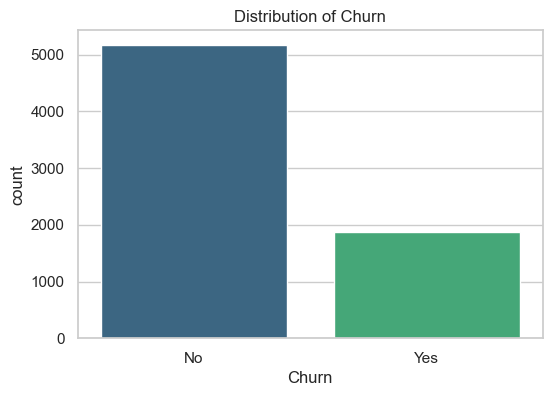

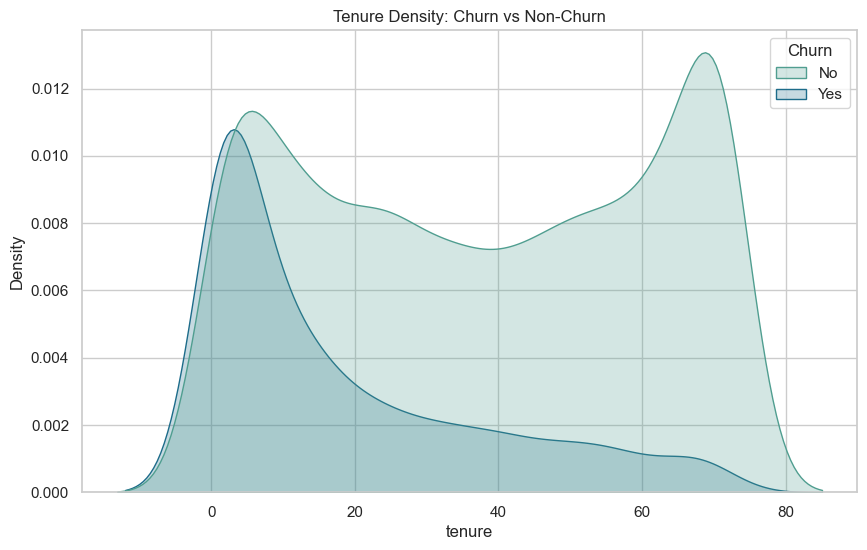

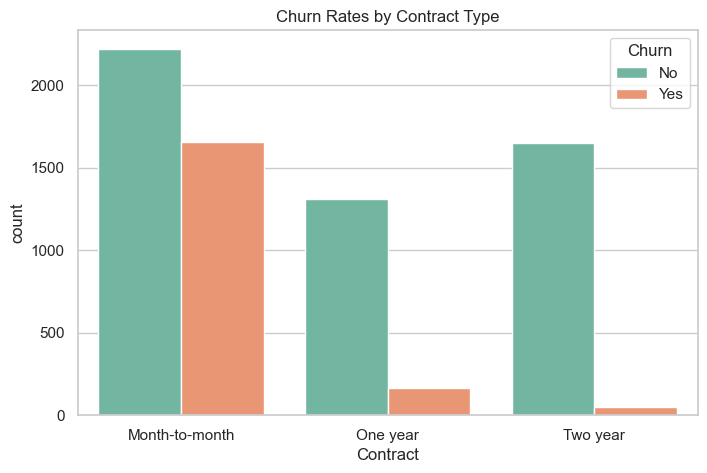

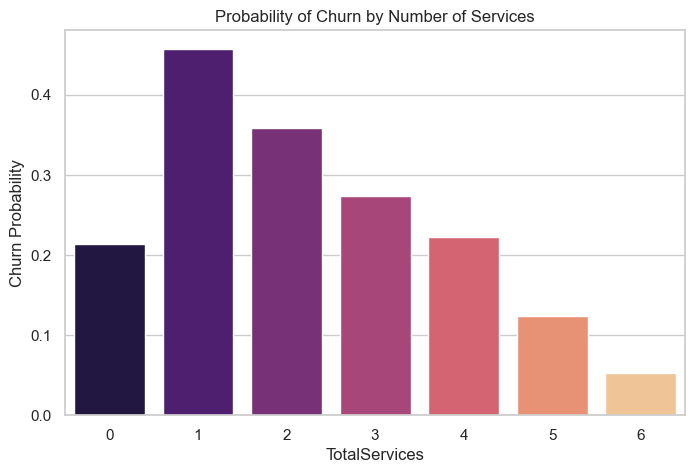

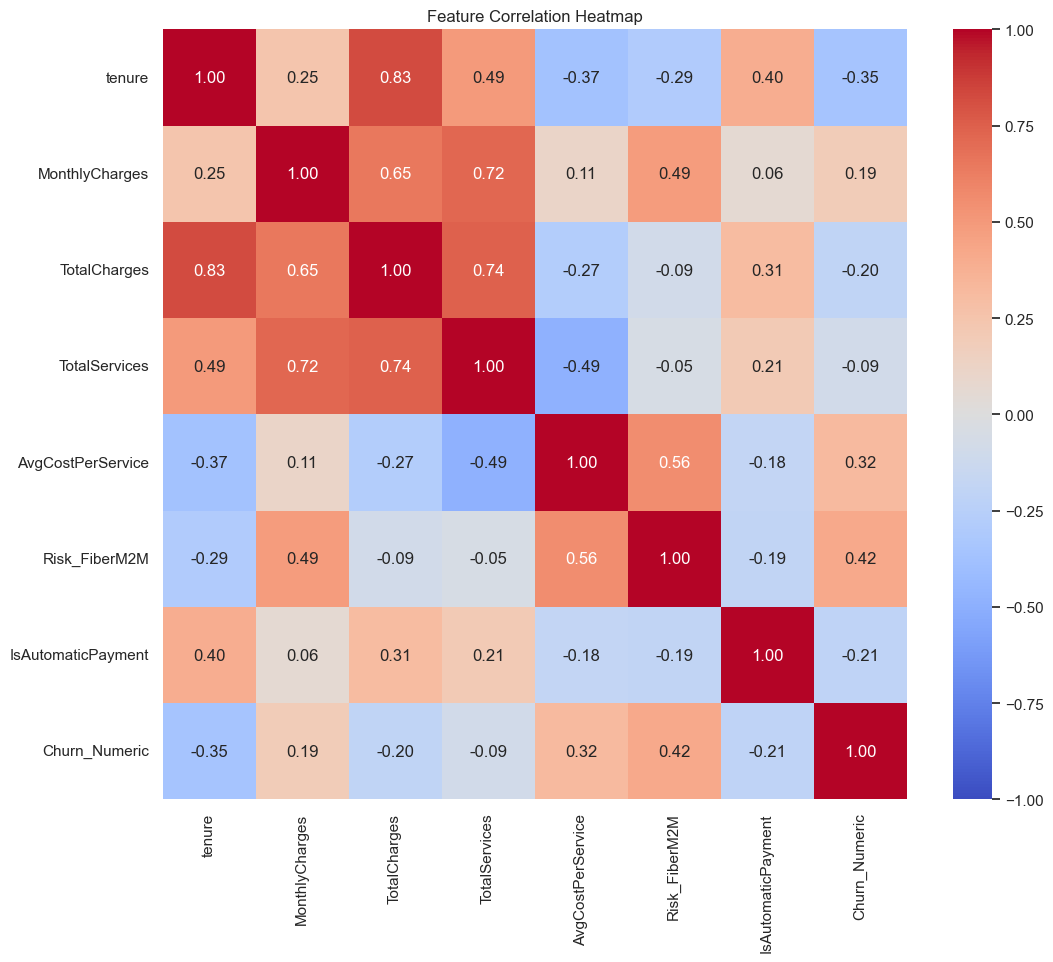

In [50]:
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ----------------------------------

# Plot 1: Churn Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=data_feature, palette='viridis')
plt.title('Distribution of Churn')
plt.savefig('eda_1_churn_dist.png')

# Plot 2: Tenure KDE by Churn
plt.figure(figsize=(10, 6))
sns.kdeplot(data=data_feature, x='tenure', hue='Churn', fill=True, palette='crest')
plt.title('Tenure Density: Churn vs Non-Churn')
plt.savefig('eda_2_tenure_kde.png')

# Plot 3: Churn by Contract Type
plt.figure(figsize=(8, 5))
sns.countplot(x='Contract', hue='Churn', data=data_feature, palette='Set2')
plt.title('Churn Rates by Contract Type')
plt.savefig('eda_3_contract_churn.png')

# Plot 4: Service Density Impact
plt.figure(figsize=(8, 5))
sns.barplot(x='TotalServices', y='Churn_Numeric', data=data_feature, palette='magma', ci=None)
plt.title('Probability of Churn by Number of Services')
plt.ylabel('Churn Probability')
plt.savefig('eda_4_service_density.png')

# Plot 5: Correlation Heatmap
plt.figure(figsize=(12, 10))
# Select numeric columns for correlation, including new features and target
corr_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'TotalServices', 'AvgCostPerService', 'Risk_FiberM2M', 'IsAutomaticPayment', 'Churn_Numeric']
corr_matrix = data_feature[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.savefig('eda_5_heatmap.png')

In [51]:
# 4. CHURN MODELLING
# ------------------
# Drop non-predictive or target-leaky columns for X
# drop customerID (id), Churn (target string), Churn_Numeric (target int)
# We keep the original categorical columns to encode them, but drop 'TenureGroup' as we have 'tenure'
X_raw = data_feature.drop(columns=['customerID', 'Churn', 'Churn_Numeric', 'TenureGroup'])
y = data_feature['Churn_Numeric']

# One-Hot Encoding
X_encoded = pd.get_dummies(X_raw, drop_first=True)

# Train-Test Split (Stratified to maintain churn ratio)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# Scaling (Important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model A: Logistic Regression (Baseline, Interpretable)
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Model B: Random Forest (Non-linear, robust)
rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42) # Limited depth to prevent overfitting
rf.fit(X_train, y_train) # Tree models don't strictly need scaling
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

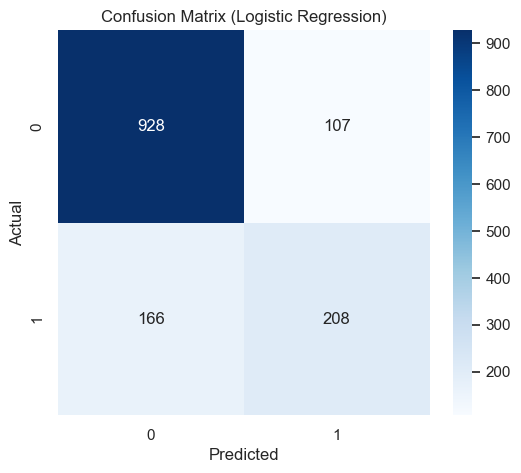

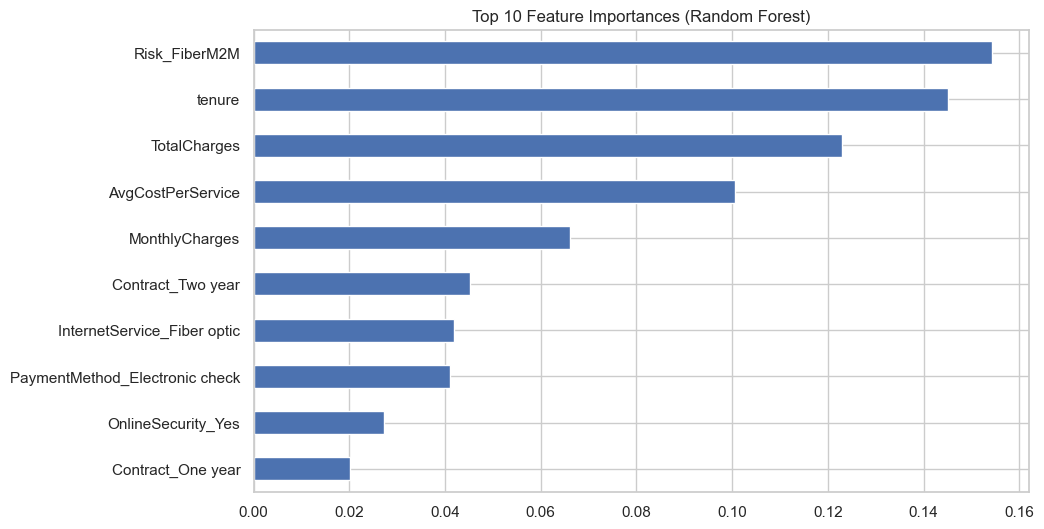

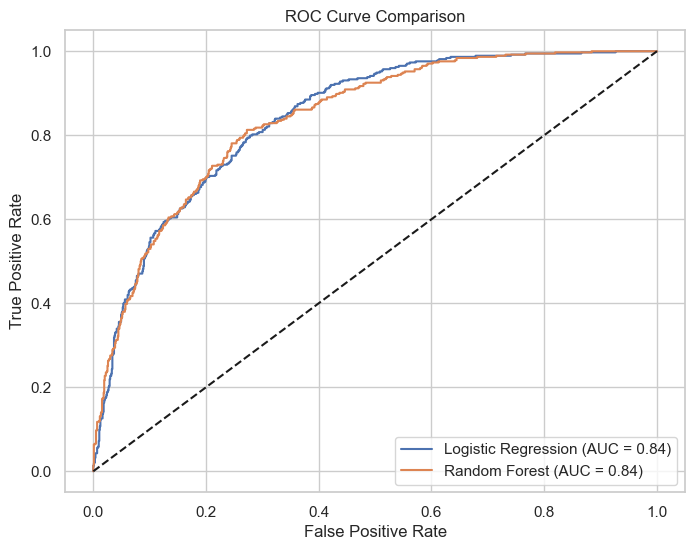

In [52]:
# 5. EVALUATION
# -------------
# Confusion Matrix (Logistic Regression)
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Logistic Regression)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('eval_confusion_matrix.png')

# Feature Importance (Random Forest)
feat_imp = pd.Series(rf.feature_importances_, index=X_encoded.columns).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
feat_imp.plot(kind='barh', color='#4c72b0')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.savefig('eval_feature_importance.png')

# ROC Curve comparison
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob_lr):.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_prob_rf):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.savefig('eval_roc_curve.png')

In [54]:
# 6. POSTDICTIVE ANALYSIS EXPORT
# ----------------------------
results_df = X_test.copy()
# Add back original values for readability (reverse dummies partially or just use index)
# Ideally join back to original DF using index
results_df = data_feature.loc[X_test.index].copy()
results_df['Actual_Churn'] = y_test
results_df['Pred_Prob_LR'] = y_prob_lr
results_df['Pred_Label_LR'] = y_pred_lr
results_df['Pred_Prob_RF'] = y_prob_rf
results_df['Pred_Prob_RF'] = y_pred_rf

results_df.to_csv('final_churn_prediction_analysis.csv', index=False)

print("Models Trained.")
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf))

Models Trained.
Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Random Forest Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409

